<h1>Regression House Price Prediction

<h5>Using Polynomial Regresion of degree 3 in two variables $x_1$,$x_2$ and y</h5>
<p>
$h(x) = w_0 + w_1 x_1+ w_2 x_2 + w_3 x_1^2 + w_4 x_1 x_2 + w_5 x_2^2 + w_6 x_2^3  + w_7 x_1 x_2^2 + w_8 x_1^2 x_2 + w_9 x_1^3 $
  
</p> 

In [1]:
import numpy as np 
import pandas as pd 
import sklearn.utils as skutils
import sklearn.model_selection as skmodelsel
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

<H1>Read Data from CSV

In [3]:
df = pd.read_csv('../input/HousePriceDS/HousePriceData.csv')   #Training Dataset
df = skutils.shuffle(df)
dfTrain, dfValid = skmodelsel.train_test_split(df, test_size=0.2)
dfTrain.head()

,FloorArea,BedRooms,Price
19,3031,4,599000
12,1890,3,329999
4,3000,4,539900
38,4215,4,549000
23,1962,4,259900


<h5> Visualize Data

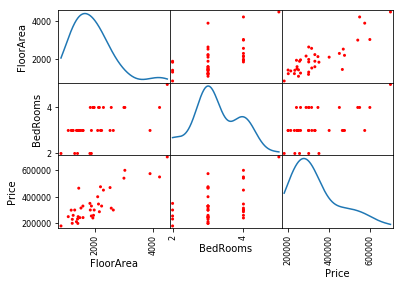

In [4]:
pd.plotting.scatter_matrix(dfTrain, alpha=1, diagonal='kde',color='r')
plt.show()

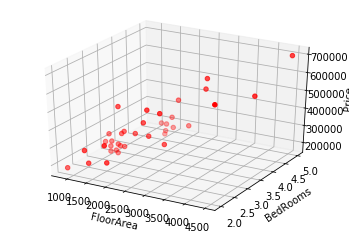

In [5]:
#%matplotlib notebook
plt3D = plt.figure().gca(projection='3d')
plt3D.scatter(dfTrain['FloorArea'], dfTrain['BedRooms'], dfTrain['Price'],color="r")
plt3D.set_xlabel('FloorArea')
plt3D.set_ylabel('BedRooms')
plt3D.set_zlabel('Price')
plt.show()

<h1>Extract Input Feature to <b>X </b>and Label to <b>y</b>

In [6]:
def extractFeatures(df):
    df_Features=df.loc[:,['FloorArea','BedRooms']]
    df_Label=df.loc[:,['Price']]
    X=df_Features.values
    Y=df_Label.values
    return X,Y

In [7]:
X,Y=extractFeatures(dfTrain)

<h5>Normalize Input    

In [8]:
SMean=np.mean(X,axis=0)   
SDev=np.std(X,axis=0)
def NormalizeInput(X,SMean,SDev):   
    XNorm=(X-SMean)/SDev
    return XNorm

In [9]:
XNorm=NormalizeInput(X,SMean,SDev)

<h5>Add Polynomial Features

In [10]:
def mapFeature(X,degree):
    
    sz=X.shape[1]
    if (sz==2):
        sz=(degree+1)*(degree+2)/2
        sz=int(sz)
    else:
         sz=degree+1
    out=np.ones((X.shape[0],sz))     #Adding Bias W0

    sz=X.shape[1]
    if (sz==2):
        X1=X[:, 0:1]
        X2=X[:, 1:2]
        col=1
        for i in range(1,degree+1):        
            for j in range(0,i+1):
                out[:,col:col+1]= np.multiply(np.power(X1,i-j),np.power(X2,j))    
                col+=1
        return out
    else:
        for i in range(1,degree+1):        
            out[:,i:i+1]= np.power(X,i)
    
    return out

In [11]:
degree=3
inputX=mapFeature(XNorm,degree)  

<h1> Training

<h5> Initialization

In [12]:
batchSize=len(Y)         #no of Examples
iterations = 5000
alpha =100000000
beta1=0.9
beta2=0.999
learningDecayRate=0.998
epsilon=0.0000000001
featureCount=inputX.shape[1] 
weights=np.zeros((featureCount, 1)) #initialize Weight Paramters
vDW=np.zeros((featureCount, 1))
sDW=np.zeros((featureCount, 1))
lossList=np.zeros((iterations,1),dtype=float)  #for plotting loss curve

<h5> Gradient Descent Updates

In [13]:

for k in range(iterations):
    #nth iteration
    t=k+1
    
    #Hypothesis
    hypothesis=np.matmul( inputX,weights)           
    
    #Loss
    loss=hypothesis-Y  
    
    
    #derivative
    dW=np.matmul(inputX.T,loss)  #Derivative
   
    #learning Rate decrease as training progresses 
    alpha=alpha*learningDecayRate
    
    #gradient Update
    vDW = (beta1) *vDW+ (1-beta1) *dW        #Momentum  
    sDW = (beta2) *sDW+ (1-beta2) *(dW**2)   #RMSProp
    
    vDWc =vDW/(1-beta1**t)
    sDWc =sDW/(1-beta2**t)
    #weights=weights - (alpha/batchSize)*dW       #normal
    #weights=weights - (alpha/batchSize)*vDW     #Momentum   
    #weights=weights - (alpha/batchSize)*dW/np.sqrt(csDW+epsilon)     #RMSProp 
    weights=weights - (alpha/batchSize)*(vDWc/(np.sqrt(sDWc)+epsilon)) #Adam          
    
    
    #Compute Loss for Plotting
    newLoss=np.matmul( inputX,weights)-Y
    newLossSqr=np.multiply(newLoss,newLoss)
    lossList[k]=(1.0/(2.0*batchSize))* np.sum(newLossSqr)

print("{0:.15f}".format(lossList[iterations-1][0]))

1838525790.216214418411255


<h1>Plot Loss Curve

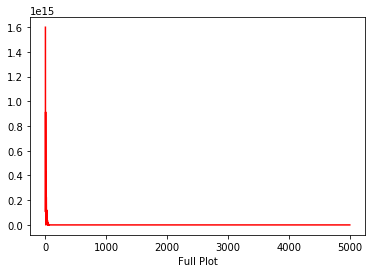

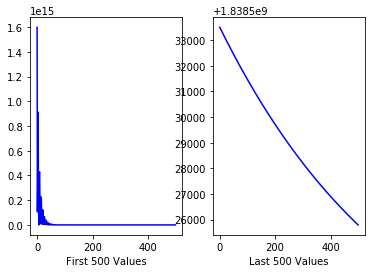

In [14]:
plt.subplot(111)
plt.plot(lossList,color='r')
plt.xlabel('Full Plot')
plt.show()

plt.subplot(121)
plt.plot(lossList[0:500],color='b')
plt.xlabel('First 500 Values')


plt.subplot(122)
plt.plot(lossList[len(lossList)-500:len(lossList)],color='b')
plt.xlabel('Last 500 Values')
plt.show()

<h1> Prediction/RMSE Evaluation

In [15]:
def predict(X,weights,SMean,SDev,degree):
    XNorm=NormalizeInput(X,SMean,SDev)
    inputX=mapFeature(XNorm,degree)
    PY=np.matmul(inputX, weights)
    return PY


In [16]:
def getRMSE(aY,pY):
    Error=aY- pY
    ErrorSqr=Error**2
    MSE=ErrorSqr.mean()
    RMSE=np.sqrt(MSE)
    return RMSE

<h5>RMSE on Training Data

In [17]:
pY=predict(X, weights,SMean,SDev,degree)  # Predict with bias feature added
print("{0:.15f}".format(getRMSE(Y, pY)))

60638.697054211421346


<h5> RMSE on Validation Data

In [18]:
vX,vY=extractFeatures(dfValid)
pY=predict(vX, weights,SMean,SDev,degree)  # Predict with bias feature added
print("{0:.15f}".format(getRMSE(vY, pY)))

54051.949484418488282


<h2> Model Final Verification

<h5> Training Data Prediction visualization in 2D (Floor Area vs Volume)

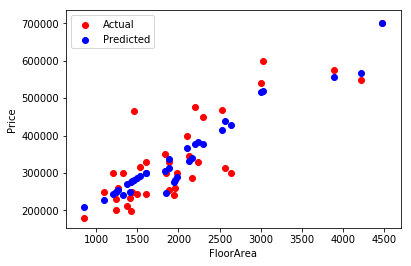

In [19]:
pY=predict(X, weights,SMean,SDev,degree)  # Predict with bias feature added
plt.scatter(X[:,0],Y,color="r")
plt.scatter(X[:,0],pY[:,0],color="b")
plt.xlabel("FloorArea")
plt.ylabel("Price")
plt.legend(["Actual","Predicted"])
plt.show()

<h5> Training Data Prediction visualization in 2D (BedRooms Area vs Volume)

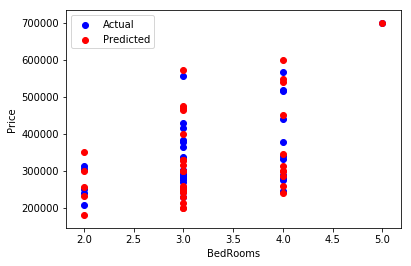

In [20]:
plt.close()
pY=predict(X, weights,SMean,SDev,degree)  # Predict with bias feature added
plt.scatter(X[:,1],pY[:,0],color="b")
plt.scatter(X[:,1],Y,color="r")
plt.xlabel("BedRooms")
plt.ylabel("Price")
plt.legend(["Actual","Predicted"])
plt.show()

<h5> Training Data Prediction in 3D

<IPython.core.display.Javascript object>


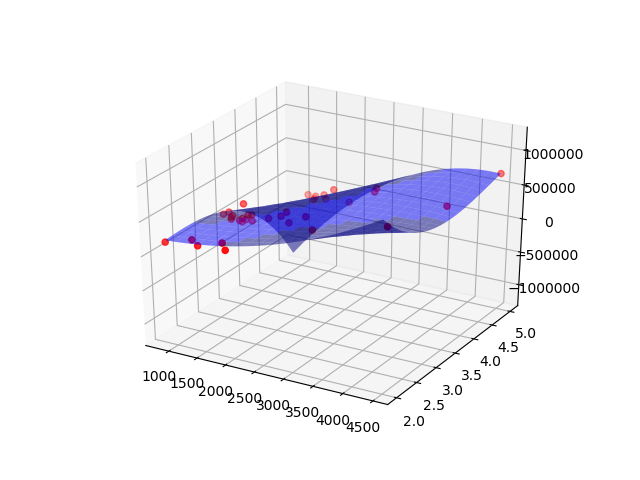

In [21]:
%matplotlib notebook
fig = plt.figure()
plt3D = fig.add_subplot(111, projection='3d')   
plt3D.scatter(X[:,0],X[:,1],Y,marker="o",color="r")

x_min, x_max = X[:, 0].min() , X[:, 0].max() 
y_min, y_max = X[:, 1].min() , X[:, 1].max() 
u = np.linspace(x_min, x_max,20) 
v = np.linspace(y_min, y_max, 20) 
z = np.zeros(( len(u), len(v) )) 
U,V=np.meshgrid(u,v)
for i in range(len(u)): 
    for j in range(len(v)): 
        uv= np.column_stack((np.array([[u[i]]]),np.array([[v[j]]])))
        pv =predict(uv, weights,SMean,SDev,degree)
        z[i,j] =pv[0][0]
z = np.transpose(z) 
plt3D.plot_surface(U,V,z,alpha=0.5,color='b')
plt.show()